In [14]:
import osmnx as ox
import networkx as nx
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.15.1'

In [15]:
nx.__version__

'2.4'

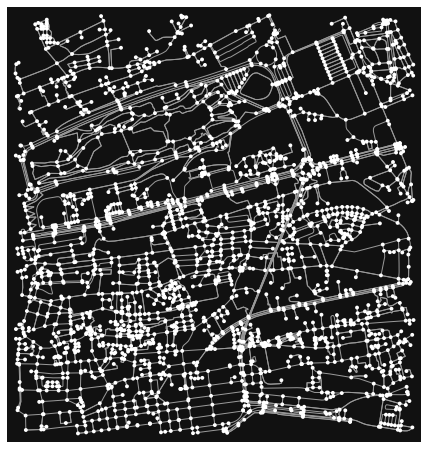

In [16]:
# get a graph for some city
# Simplification is normally done by OSMnx automatically under the hood
#G = ox.graph_from_point((43.46331, -3.79892), dist=700, dist_type='network')
#G = ox.graph_from_place('Hoboken, New Jersey', network_type = 'drive')
G = ox.graph_from_bbox(43.4784,43.4620,-3.8090,-3.7875)
fig, ax = ox.plot_graph(G)

In [17]:
# Simplify Network

Roads = list(G.edges())
# keep {'primary', 'secondary', 'tertiary', 'residential', 'trunk'} only
for r in Roads:
    key = [a for a in G.adj[r[0]][r[1]].keys()]
    proper = G.adj[r[0]][r[1]][key[0]]['highway']
    if 'motor' in proper or 'motor_link' in proper:
        G.remove_edge(r[0],r[1])
# Node list
Roads = list(G.edges())
node_list = []
for r in Roads:
    node_list.append(r[0])
    node_list.append(r[1])
node_list = set(node_list)
# remove wrong roads with (a,a)
Roads = list(G.edges)
for r in Roads:
    if r[0]==r[1]:
        G.remove_edge(r[0],r[1])
# remove duplicate roads
do = 1
while do > 0:
    store_edge = []
    Roads = list(G.edges())
    for r in Roads:
        if r in store_edge:
            G.remove_edge(r[0],r[1])
        else:
            store_edge.append(r)
    do = len(Roads)-len(G.edges())
# we need an undirected graph to find neighbors of each node
G_undir = G.to_undirected()
# remove dead end and single node
do = 1
while do > 0:
    Nodes = list(G.nodes())
    G_undir = G.to_undirected()
    for n in Nodes:
        if n not in node_list or len([a for a in G_undir.neighbors(n)]) == 1:
            G.remove_node(n)
    do = len(Nodes) - len(G)

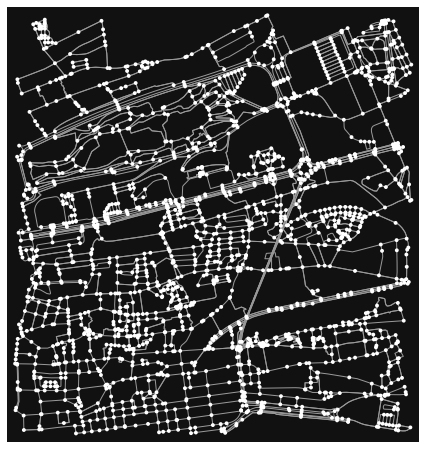

In [18]:
fig, ax = ox.plot_graph(G)

In [19]:
# Remove unnecessary roads
Roads = list(G.edges())
# keep {'primary', 'secondary', 'tertiary', 'residential', 'trunk'} only
for r in Roads:
    key = [a for a in G.adj[r[0]][r[1]].keys()]
    proper = G.adj[r[0]][r[1]][key[0]]['highway']
    if 'motor' in proper or 'motor_link' in proper:
        G.remove_edge(r[0],r[1])
# Node list
Roads = list(G.edges())
node_list = []
for r in Roads:
    node_list.append(r[0])
    node_list.append(r[1])
node_list = set(node_list)
# remove wrong roads with (a,a)
Roads = list(G.edges)
for r in Roads:
    if r[0]==r[1]:
        G.remove_edge(r[0],r[1])
# remove duplicate roads
do = 1
while do > 0:
    store_edge = []
    Roads = list(G.edges())
    for r in Roads:
        if r in store_edge:
            G.remove_edge(r[0],r[1])
        else:
            store_edge.append(r)
    do = len(Roads)-len(G.edges())
# we need an undirected graph to find neighbors of each node
G_undir = G.to_undirected()
# remove dead end and single node
do = 1
while do > 0:
    Nodes = list(G.nodes())
    G_undir = G.to_undirected()
    for n in Nodes:
        if n not in node_list or len([a for a in G_undir.neighbors(n)]) == 1:
            G.remove_node(n)
    do = len(Nodes) - len(G)

In [20]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

3091833.864431296

In [21]:
G_proj

In [22]:
# show some basic stats about the network
stats = ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
for key in sorted(stats.keys()):
    print(key)

circuity_avg
clean_intersection_count
clean_intersection_density_km
edge_density_km
edge_length_avg
edge_length_total
intersection_count
intersection_density_km
k_avg
m
n
node_density_km
self_loop_proportion
street_density_km
street_length_avg
street_length_total
street_segments_count
streets_per_node_avg
streets_per_node_counts
streets_per_node_proportion


In [23]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


In [24]:
# pull up some stat's value
more_stats['radius']

1936.9150000000002

In [25]:
# Visualize street centrality
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa

edge_centrality = nx.closeness_centrality(nx.line_graph(G))

In [26]:
# get the nearest network node to each point
# we should use (y,x) to find the corresponding point
orig_node = ox.get_nearest_node(G, (43.4817, -3.8153))
dest_node = ox.get_nearest_node(G, (43.4257, -3.8268))

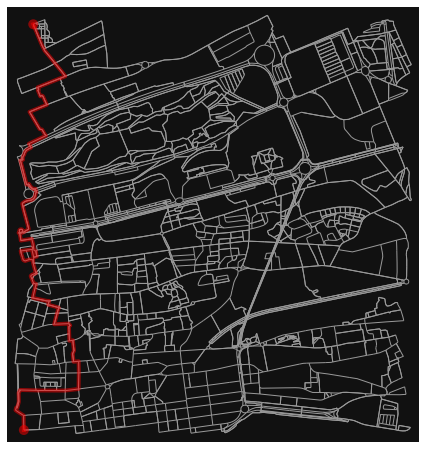

In [27]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [28]:
# how long is our route in meters?
nx.shortest_path_length(G, orig_node, dest_node, weight='length')

2971.9910000000004